# MA3315: Introduction to Visual Computing
## Assignment 1

This assignment has two problems. 

Let us load the required libraries first. 

In [60]:
from __future__ import print_function
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{2}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 1.D Doule thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

In [61]:
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import convolve2d
from math import pi

def derivative(img):
    S = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype='float')
    resx = convolve2d(img, S, mode='same')
    resy = convolve2d(img, S.T, mode='same')
    return resx, resy

def padding(img):
    padded = np.zeros((img.shape[0]+2, img.shape[1]+2))
    for x in range(1, img.shape[0]+1):
        for y in range(1, img.shape[1]+1):
            padded[x, y] = img[x-1, y-1]
    return padded

def gradient(img):
    resx, resy = derivative(img)
    mag = np.sqrt(resx**2+resy**2)
    direc = np.arctan(resy/resx)
    return mag, direc

def non_maximum_suppression(g_mag, g_dir):
    g_max = np.zeros_like(g_mag)
    directions = np.array([0, pi/4, pi/2, 3*pi/4])
    padded = padding(g_mag)
    for x in range(g_mag.shape[0]):
        for y in range(g_mag.shape[1]):
            direc = np.argmin(np.abs(directions-g_dir[x, y]))
            a = 0 if direc==2 else 1
            b = 0 if direc==0 else 1
            sign = -1 if direc==3 else 1
            g_max[x, y] = g_mag[x, y] if g_mag[x, y]>=padded[x+1+a, y+1+sign*b] and g_mag[x, y]>=padded[x-1-a, y-1-sign*b] else 0
    return g_max
         
def double_thresholding(g_max, thresh_lo, thresh_hi):
    thresh_img = np.full(g_max.shape, 2)
    for x in range(g_max.shape[0]):
        for y in range(g_max.shape[1]):
            if g_max[x, y]<thresh_lo:
                thresh_img[x, y] = 0
            elif g_max[x, y]< thresh_hi:
                thresh_img[x, y] = 1
    return thresh_img
            
def connectivity(thresh_img):
    edge_img = np.zeros_like(thresh_img)
    padded = padding(edge_img)
    for x in range(edge_img.shape[0]):
        for y in range(edge_img.shape[1]):
            if thresh_img[x, y]==2:
                edge_img[x, y]=1
            elif thresh_img[x, y]==1:
                l = [-1, 0, 1]
                connect = [padded[x+1+a, y+1+b] for a in l for b in l if (a!=0 or b!=0)]
                if any(connect)==2:
                    edge_img[x, y] = 1
    return edge_img
            
def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_filter(img, 1.4)
    
    # Find gradient magnitude and direction
    g_mag, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_mag, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


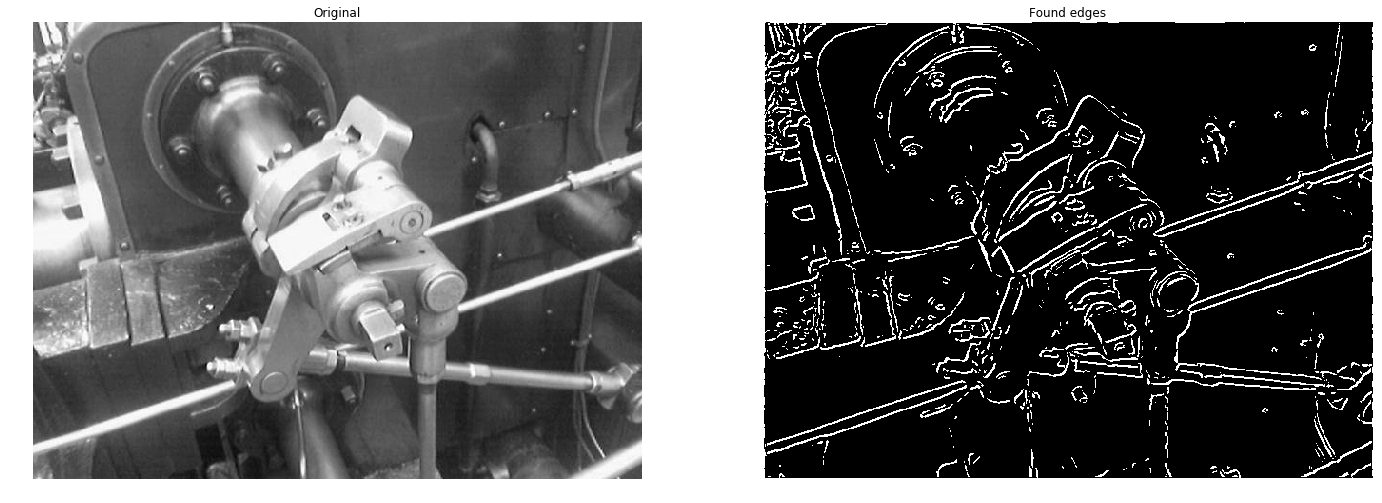

In [62]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = img/255
edges = canny_edge_detector(img, 0.2, 0.25)

plt.figure(figsize=(24,12))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

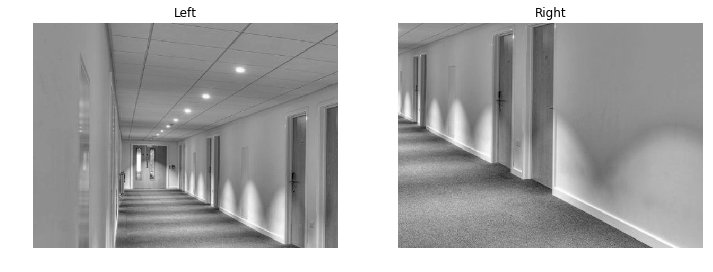

In [63]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)/255

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)/255

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

In [96]:
import random

def harris_corner_detector(img, thresh):
    Ix, Iy = derivative(img)
    Ixx = padding(Ix**2)
    Ixy = padding(Ix*Iy)
    Iyy = padding(Iy**2)
    corner_img = np.zeros_like(img)
    corner_list = []
    f = np.zeros_like(img)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            H = np.zeros((2,2))
            H[0, 0] = np.sum(Ixx[x:x+3, y:y+3])
            H[0, 1] = np.sum(Ixy[x:x+3, y:y+3])
            H[1, 0] = H[0, 1]
            H[1, 1] = np.sum(Ixx[x:x+3, y:y+3])
            det = np.linalg.det(H)
            tr = H[0, 0] + H[1, 1]
            f_loc = det/tr
            f[x, y] = f_loc if f_loc > thresh else 0
    padded = padding(f)       
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            l=[-1, 0, 1]
            if not(f[x, y]==0 or f[x, y]<np.max([padded[x+1+a, y+1+b] for a in l for b in l])):
                corner_img[x, y] = 1
                corner_list.append((x, y))
    return corner_img, corner_list
    
def find_random_pair(possible_points):
    (c_left,c_right) = random.choice(possible_points)
    return c_left, c_right

    
def find_translation_vector(c_left, c_right):
    return c_right[0]-c_left[0], c_right[1]-c_left[1]
  
def compute_error(corners_left, corners_right, corners_list_left, corners_list_right, x_trans, y_trans):
    n = corners_left.shape[0]
    m = corners_left.shape[1]
    overlap = [(x, y) for (x, y) in corners_list_left if x>=max(0, -x_trans) and x<min(n, n-x_trans) and y>=max(0, -y_trans) and y<min(m, m-y_trans)]
    errors = 0
    total = 0
    for (x,y) in overlap:
        test = x+x_trans<corners_right.shape[0] and y+y_trans<corners_right.shape[1]
        if test:
            if corners_right[x+x_trans, y+y_trans] != 1:
                errors += 1
        total += 1
    return (errors+10)/total #trying to give small overlapping solutions bigger error

def place(left, right, x_trans, y_trans, x, y):
    n_left, m_left = left.shape
    n_right, m_right = right.shape
    if x_trans>=0:
        if y_trans>=0:
            if (x<x_trans and y>=m_right) or (x>=n_right and y<y_trans):
                return 0
            elif x<x_trans or y<y_trans:
                return right[x, y]
            elif x>=n_right or y>=m_right:
                return left[x-x_trans,y-y_trans]
            else:
                return (right[x, y]+left[x-x_trans, y-y_trans])/2
        else:
            if (x<x_trans and y<-y_trans) or (x>=n_right and y>=m_left):
                return 0
            elif x<x_trans or y>=m_left:
                return right[x, y+y_trans]
            elif x>=n_right or y<-y_trans:
                return left[x-x_trans, y]
            else:
                return (right[x, y+y_trans]+left[x-x_trans, y])/2
    else: 
        if y_trans>=0:
            if (x<-x_trans and y<y_trans) or (x>=n_left and y>=m_right):
                return 0
            elif x>=n_left or y<y_trans:
                return right[x+x_trans, y]
            elif x<-x_trans or y>=m_right:
                return left[x, y-y_trans]
            else:
                return (right[x+x_trans, y]+left[x, y-y_trans])/2
        else:
            if (x<-x_trans and y>=m_left) or (x>=n_left and y<-y_trans):
                return 0
            elif x>=n_left or y>=m_left:
                return right[x+x_trans, y+y_trans]
            elif x<-x_trans or y<-y_trans:
                return left[x, y]
            else:
                return (right[x+x_trans, y+y_trans]+left[x,y])/2
            
                 
def stitch_images(left, right, max_tries=1000, thresh = 0.1):
    # Find corner points
    corners_left, corners_list_left  = harris_corner_detector(left, thresh)
    corners_right, corners_list_right = harris_corner_detector(right, thresh)
    possible_points = [((x1,y1),(x2,y2)) for (x1,y1) in corners_list_left for (x2,y2) in corners_list_right if y2<y1]
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(possible_points)
        possible_points.remove((c_left,c_right))
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Compute resulting error. 
        this_error       = compute_error(corners_left, corners_right, corners_list_left, corners_list_right, x_trans, y_trans)
        
        if this_error < best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
    
    x_trans, y_trans = best_trans
    print(best_trans)
    n = max(right.shape[0],left.shape[0]+abs(x_trans))
    m = max(right.shape[1], left.shape[1]+abs(y_trans))
    stitched_image = np.zeros((n, m))
    for x in range(n):
        for y in range(m):
            stitched_image[x, y] = place(left, right, x_trans, y_trans, x, y)
    return stitched_image

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


(-154, -299)


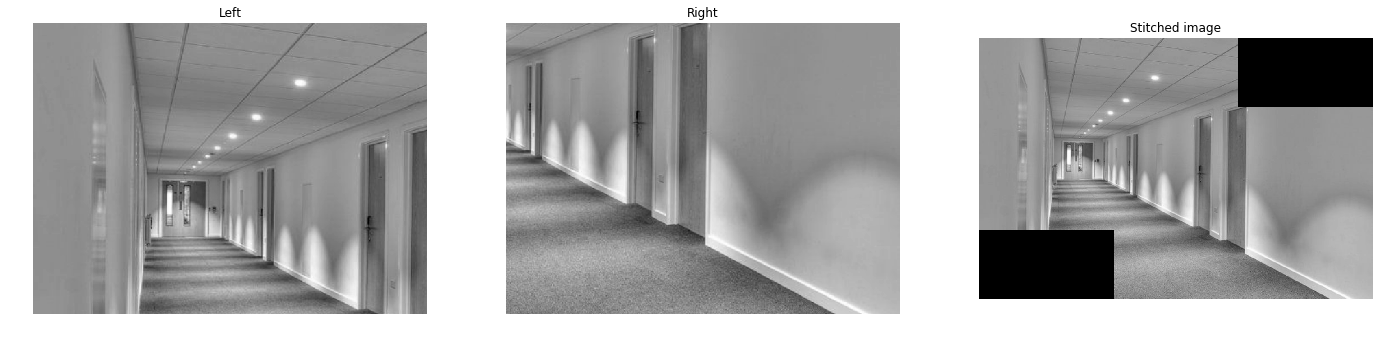

In [97]:
stitched_image = stitch_images(left_img, right_img, 5000, 0.2)

plt.figure(figsize=(24,12))

plt.subplot(1, 3, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 3, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.subplot(1, 3, 3)
plt.imshow(stitched_image, cmap='gray')
plt.axis('off')
plt.title('Stitched image')

plt.show()

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 